# Python

***
###

In [1]:
import os
import collections
import itertools
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

In [2]:
# Generate assembled_kmer_motifs
def sequence_kmer_pileup(seq, query_kmers):
    """
    Given a sequence and query kmers, return a binary matrix where each row represents if that kmer is in that position
    >>> sequence_kmer_pileup("ACTGCGTACG", ['ACT', 'GCG', 'TACG'])
    array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
    >>> sequence_kmer_pileup("ACTGCGTACG", ['ACT', 'GCGT', 'TACG'])
    array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
    >>> sequence_kmer_pileup("AAAA", ["AAA"])
    array([[1, 2, 2, 1]])
    """
    assert isinstance(query_kmers, list)
    lengths = set([len(kmer) for kmer in query_kmers])
    retval = np.zeros((len(query_kmers), len(seq))).astype(int)
    for length in lengths:
        assert length <= len(seq), "Cannoty query a kmer against a seq shorter than that kmer"
        kmers = [seq[i:i+length] for i in range(len(seq) - length + 1)]
        kmer_to_idx = generate_all_kmers(length)
        # Row vector
        kmers_int = np.array([kmer_to_idx[k] for k in kmers if "N" not in k], dtype=int)
        # Column vector
        query_int = np.atleast_2d(np.array([kmer_to_idx[k] for k in query_kmers if len(k) == length and "N" not in k], dtype=int)).T
        # Array of where each query is found in the seq, by the first index of occurrence
        hits = np.where(query_int == kmers_int)  # Automatically broadcasts
        this_rows = np.zeros((len(query_int), len(seq)))
        for i in range(length):
            this_rows[hits[0], hits[1] + i] += 1
        retval_idx = np.array([i for i, k in enumerate(query_kmers) if len(k) == length], dtype=int)
        retval[retval_idx, ] = this_rows
    return retval

def generate_all_kmers(k, ignore_N=True):
    """
    Generate all kmers of length k, returning a dictionary mapping each kmer to an index in the list of kmers
    """
    alphabet = "ACGT"
    if not ignore_N:
        alphabet += "N"
    possible_kmers = itertools.product(alphabet, repeat=k)
    retval = collections.OrderedDict()
    for i, kmer in enumerate(possible_kmers):
        retval[''.join(kmer)] = i
    return retval

def find_long_runs(num_sequence, l):
    """
    Return the index and length of all run non zero elements of length greater than l
    Primarily intended as a helper function for the below function assemble_kmer_motifs
    """
    chunked = [(k, list(g)) for k, g in itertools.groupby(num_sequence)]
    retval = [(i, len(g)) for i, (k, g) in enumerate(chunked) if k and len(g) > l]
    return retval

def connect_nearby_runs(pileup_flat, allowed_gap_num):
    """
    Given a binary pileup (1 if has something, 0 if nothing), return a binary pileup
    where pileups with allowed_gap_num between them are connected
    >>> connect_nearby_runs(np.array([1, 1, 1, 0, 1, 1, 1]), 1)
    array([1, 1, 1, 1, 1, 1, 1])
    >>> connect_nearby_runs(np.array([1, 1, 1, 0, 0, 1, 1, 0]), 2)
    array([1, 1, 1, 1, 1, 1, 1, 0])
    >>> connect_nearby_runs(np.array([1, 1, 0, 0, 0, 1, 1]), 1)
    array([1, 1, 0, 0, 0, 1, 1])
    >>> connect_nearby_runs(np.array([0, 0, 1, 1, 0, 0, 1]), 2)
    array([0, 0, 1, 1, 1, 1, 1])
    """
    chunked = [(k, list(g)) for k, g in itertools.groupby(list(pileup_flat))]
    retval = []
    for i, (item, group) in enumerate(chunked):
        if not item and len(group) <= allowed_gap_num and 0 < i < len(chunked) - 1:
            retval.extend([1] * len(group))
        else:
            retval.extend(group)
    return np.array(retval, dtype=int)

def assemble_kmer_motifs(seq, kmers, min_len=10, gap_allowed=2):
    """Given a sequence and kmers, return a list of assembled kmers that are at least min_len"""
    try:
        pileup = sequence_kmer_pileup(seq, kmers)
    except AssertionError:
        return []
    pileup_flat = np.clip(np.sum(pileup, axis=0), 0, 1)  # Flatten
    pileup_flat = connect_nearby_runs(pileup_flat, gap_allowed)  # Connect runs that are separated by 1 gap
    motif_idx = find_long_runs(pileup_flat, l=min_len)
    retval = [seq[i:i+l] for i, l in motif_idx]
    # Sanity check against weird off by 1 indexing errors
    assert all([len(s) == l for s, (_i, l) in zip(retval, motif_idx)])
    return retval

In [3]:
# Read multiple alignment results 

def read_msa(fname, combine_lines=True):
    """
    Read the given MSA, assumed to be in the format clustalW provides
    """
    retval = collections.defaultdict(list)
    with open(fname) as source:
        for line in source:
            if line.startswith("CLUSTAL") or not line.strip():
                continue
            tokens = line.strip().split()
            seq_id, aln= tokens
            retval[seq_id].append(aln)
    if combine_lines:
        retval = {k: ''.join(v) for k, v in retval.items()}
    return retval

def _fetch_kmer_from_msa_i(i, seed_seq, msa, min_len, min_reps):
    """
    Helper function for below
    Given the index in the msa, extend the kmer as long as possible while maintaining the minimum reps
    """
    # Filter out irrelevant sequences and chop off prefix that doesn't match
    relevant_seqs = [m[i:] for m in msa if m[i:i+min_len] == seed_seq]
    num_matching = len(relevant_seqs)
    msa_len = len(relevant_seqs[0])

    extended = []
    # Extend the seed sequence
    for combo in itertools.combinations(relevant_seqs, min_reps):
        # Enumerate all the ways we can find the given support
        this_seq = []
        for j in range(len(combo[0])):
            jth_bases = set([c[j] for c in combo])
            if (len(jth_bases) != 1) or ('-' in jth_bases):
                break
            this_seq.append(jth_bases.pop())
        extended.append(''.join(this_seq))
    # Tuples of length and num occurrences
    extended_properties = [(len(s), len([m for m in relevant_seqs if s in m])) for s in extended]
    extended_sorted = [seq for _prop, seq in sorted(zip(extended_properties, extended))]
    return extended_sorted[0]

def find_motifs_in_msa(msa, min_len=7, min_reps=3):
    """
    Find motifs in the msa with the given minimum length and reps
    msa is expected to be an iterable of sequences
    """
    unique_lenths = set([len(m) for m in msa])
    assert len(unique_lenths) == 1, "All MSA sequences must be of the same length"
    msa_len = unique_lenths.pop()

    # First find seeds(with min_length) where we know there are hits
    hits = []
    for i in range(msa_len - min_len): # i refer to the start pos of the kmer
    # for i in range(35 - 7):
        block = [m[i:i+min_len] for m in msa]
        block_no_gaps = [m for m in block if "-" not in m]
        if not block_no_gaps:
            continue
        block_counter = collections.Counter(block_no_gaps)
        for kmer, count in block_counter.items():
            if count >= min_reps:
                hits.append((i, kmer))
    # Extend each hit to maximum length
    hits_extended = [_fetch_kmer_from_msa_i(hit[0], hit[1], msa=msa, min_len=min_len, min_reps=min_reps) for hit in hits]
    # Filter out hits that are sub-sequences of other hits
    hits_extended.sort(key=len, reverse=True)  # Sort by descending length
    hits_extended_dedup = []
    for hit in hits_extended:  # Subsequences must be shorter
        if any([hit in longer for longer in hits_extended_dedup]):
            continue
        hits_extended_dedup.append(hit)
    return hits_extended_dedup

***
###   

##  1. Load files (Feature Matrix,SHAP value and kmer_group)  

In [4]:
Feature_Matrix_path = "../03_Model_Construction/01_Machine_Learning_Model/01_ML_Model_Output"
SHAP_value_path = "./01_SHAP_kmer_Output"
kmer_group_path = "./02_SHAP_kmer_Zscore_Output"
output_path = "./03_Nuc_Cyto_kmer_assembly_Output"
if not (os.path.exists(output_path)):
    os.mkdir(output_path)

# load kmer file
df_kmer_345 = pd.read_csv(os.path.join(Feature_Matrix_path,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)
transcript_id = df_kmer_345['ensembl_transcript_id']
# convert to x:kmer-freq , y:label
del df_kmer_345['ensembl_transcript_id']
x_kmer = df_kmer_345.values
y_kmer = np.array(df_kmer_345.index)

# read shap_df and mRNA_kmer_group_df
shap_df = pd.read_csv(os.path.join(SHAP_value_path,"RNA-Light_mRNA_shap_df.txt"),sep = '\t')
mRNA_kmer_group_df =pd.read_csv(os.path.join(kmer_group_path,"mRNA_kmer_importance_group.txt"),sep ='\t')

***
###   

## 2. Plot SHAP value of Nuc and Cyto kmers

In [5]:
nuclear_kmers = list(mRNA_kmer_group_df.loc[mRNA_kmer_group_df["loc_group"]=="nuc"].sort_values(by=["mean_abs_shap"],ascending = False)["X"])
cytosol_kmers = list(mRNA_kmer_group_df.loc[mRNA_kmer_group_df["loc_group"]=="cyto"].sort_values(by=["mean_abs_shap"],ascending = False)["X"])

<Figure size 432x288 with 0 Axes>

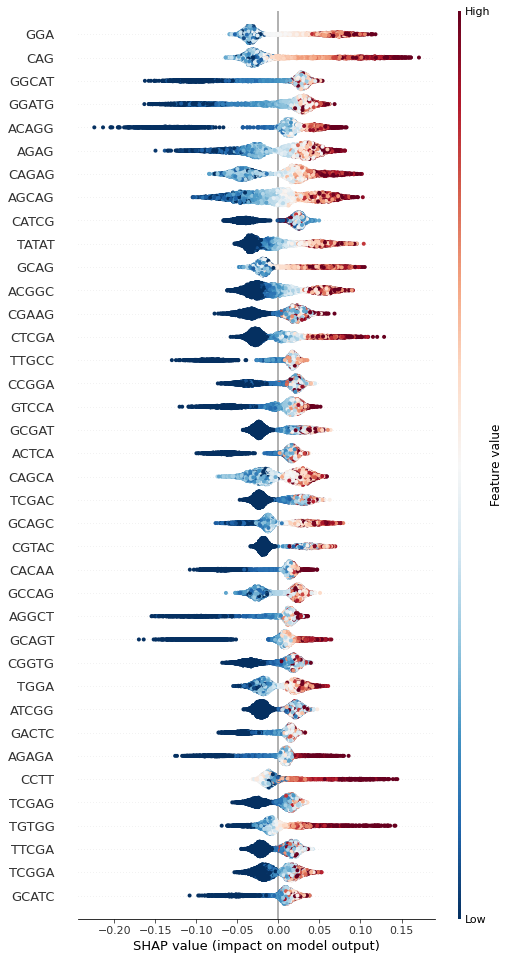

In [8]:
# Define colormap
my_colormap= plt.get_cmap("RdBu_r")

# Plot the summary without showing it
plt.figure()
shap.summary_plot(np.array(shap_df[nuclear_kmers]),df_kmer_345[nuclear_kmers],max_display = 50,show=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_colormap)
plt.savefig(os.path.join(output_path,"SHAP_nuc_favour_kmer.pdf"), format='pdf', dpi=1200)

<Figure size 432x288 with 0 Axes>

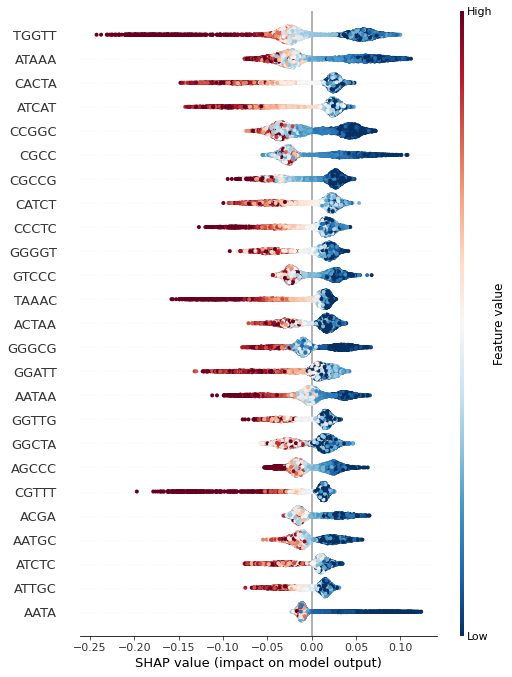

In [7]:
# Define colormap
my_colormap= plt.get_cmap("RdBu_r")

# Plot the summary without showing it
plt.figure()
shap.summary_plot(np.array(shap_df[cytosol_kmers]),df_kmer_345[cytosol_kmers],max_display = 50,show=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_colormap)
plt.savefig(os.path.join(output_path,"SHAP_cyto_favour_kmer.pdf"), format='pdf', dpi=1200)

In [9]:
for feature in nuclear_kmers:
    print(feature)

GGA
CAG
GGCAT
GGATG
ACAGG
AGAG
CAGAG
AGCAG
CATCG
TATAT
GCAG
ACGGC
CGAAG
CTCGA
TTGCC
CCGGA
GTCCA
GCGAT
ACTCA
CAGCA
TCGAC
GCAGC
CGTAC
CACAA
GCCAG
AGGCT
GCAGT
CGGTG
TGGA
ATCGG
GACTC
AGAGA
CCTT
TCGAG
TGTGG
TTCGA
TCGGA
GCATC


In [10]:
for feature in cytosol_kmers:
    print(feature)

TGGTT
ATAAA
CACTA
ATCAT
CCGGC
CGCC
CGCCG
CATCT
CCCTC
GGGGT
GTCCC
TAAAC
ACTAA
GGGCG
GGATT
AATAA
GGTTG
GGCTA
AGCCC
CGTTT
ACGA
AATGC
ATCTC
ATTGC
AATA


***
###   

## 3. Select nuclear mRNA and cytoplasmic mRNA as reference to map with corresponding kmers

In [11]:
# Get Nuc_locate_mRNAs and Cyto_Locate_mRNAs
# load data
cyto_f = "../02_Dataset/02_mRNA_info_cyto_transcript.tsv"
nuc_f = "../02_Dataset/02_mRNA_info_nuc_transcript.tsv"
dataset_cyto = pd.read_csv(cyto_f,sep='\t',index_col = False)    #2924  
dataset_nuc = pd.read_csv(nuc_f,sep='\t',index_col = False)    #2256
# Set the tag : nuclear 1 / cytosol 0
dataset_nuc['tag'] = 1;dataset_cyto['tag'] = 0
# merge the nuc and cyto dataset
dataset = pd.concat([dataset_nuc,dataset_cyto]) #5180
# remove duplicated
dataset.drop_duplicates(keep='first',subset=["ensembl_transcript_id","name","cdna"],inplace=True) # 3792
# Split to nuc and cyto
dataset_nuc = dataset[dataset["tag"]==1] #2256
dataset_cyto = dataset[dataset["tag"]==0] #2924
# Convert to list
nuc_mRNASeqs =  dataset_nuc['cdna'].tolist()
cyto_mRNASeqs = dataset_cyto['cdna'].tolist()

***
###   

## 4. Assemble kmers to candidate motifs

In [15]:
# Get assembled Nuc_favour_motif and Cyto_favour_motif
# Nuclear favour motif
nuc_motif = []
for nuc_seq in nuc_mRNASeqs:
    nuc_motif = nuc_motif + assemble_kmer_motifs(nuc_seq, nuclear_kmers, min_len=10, gap_allowed=2)
nuc_motif_df = pd.DataFrame(nuc_motif)
nuc_motif_df.to_csv(os.path.join(output_path,"nuc_favour_motifAssembl_seq.txt"),sep='\t',header = False)

# Cytolsol favour motif
cyto_motif = []
for cyto_seq in cyto_mRNASeqs:
    cyto_motif = cyto_motif + assemble_kmer_motifs(cyto_seq, cytosol_kmers, min_len=10, gap_allowed=2)
cyto_motif_df = pd.DataFrame(cyto_motif)
cyto_motif_df.to_csv(os.path.join(output_path,"cyto_favour_motifAssembl_seq.txt"),sep='\t',header = False)

***
###   

## 5. Candidate Multiple Sequence Alignment (MSA)

In [16]:
# Tab to fa
nuc_tab2fa = "seqkit tab2fx  ./03_Nuc_Cyto_kmer_assembly_Output/nuc_favour_motifAssembl_seq.txt \
> ./03_Nuc_Cyto_kmer_assembly_Output/nuc_favour_motifAssembl_seq.fa"
cyto_tab2fa = "seqkit tab2fx  ./03_Nuc_Cyto_kmer_assembly_Output/cyto_favour_motifAssembl_seq.txt \
> ./03_Nuc_Cyto_kmer_assembly_Output/cyto_favour_motifAssembl_seq.fa"

os.system(nuc_tab2fa)
os.system(cyto_tab2fa)


# MSA
nuc_clustalo = "clustalo --threads 15 -i ./03_Nuc_Cyto_kmer_assembly_Output/nuc_favour_motifAssembl_seq.fa \
-o ./03_Nuc_Cyto_kmer_assembly_Output/nuc_favour_motifAssembl_seq.cluster --outfmt clu 2>./03_Nuc_Cyto_kmer_assembly_Output/nuc_favour_clu.log"
cyto_clustalo = "clustalo --threads 15 -i ./03_Nuc_Cyto_kmer_assembly_Output/cyto_favour_motifAssembl_seq.fa \
-o ./03_Nuc_Cyto_kmer_assembly_Output/cyto_favour_motifAssembl_seq.cluster --outfmt clu 2>./03_Nuc_Cyto_kmer_assembly_Output/cyto_favour_clu.log"

os.system(nuc_clustalo)
os.system(cyto_clustalo)

0

0

0

0

***
###   

## 6. MSA to consensus motifs

In [17]:
# MSA to Motifs
# Nuc_favour_motifs
nuc_favour_msa_file = read_msa(os.path.join(output_path,"nuc_favour_motifAssembl_seq.cluster"),combine_lines=True)
nuc_favour_msa = list(nuc_favour_msa_file.values())
nuc_favour_results = find_motifs_in_msa(nuc_favour_msa, min_len=7, min_reps=3)
nuc_favour_results_df = pd.DataFrame(nuc_favour_results)
nuc_favour_results_df.to_csv(os.path.join(output_path,"nuc_favour_motif_consensus.txt"),sep='\t',header = False)
# Cyto_favour_motifs
cyto_favour_msa_file = read_msa(os.path.join(output_path,"cyto_favour_motifAssembl_seq.cluster"),combine_lines=True)
cyto_favour_msa = list(cyto_favour_msa_file.values())
cyto_favour_results = find_motifs_in_msa(cyto_favour_msa, min_len=7, min_reps=3)
cyto_favour_results_df = pd.DataFrame(cyto_favour_results)
cyto_favour_results_df.to_csv(os.path.join(output_path,"cyto_favour_motif_consensus.txt"),sep='\t',header = False)